In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sps
import pymc3 as pm

import seaborn as sns
sns.set(font_scale=1.5)

red = '#FF3300'
blue = '#0099CC'
green = '#00CC66'

Загрузите данные `flats_moscow.txt` о стоимости квартир в Москве

In [2]:
data = pd.read_csv('./flats_moscow.txt', sep='\t', index_col=0)
data.head()

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
n,,,,,,,,,,
1,81,58,40,6.0,12.5,7,1,1,1,3
2,75,44,28,6.0,13.5,7,1,0,1,6
3,128,70,42,6.0,14.5,3,1,1,1,3
4,95,61,37,6.0,13.5,7,1,0,1,1
5,330,104,60,11.0,10.5,7,0,1,1,3


Постройте график зависимости цены квартиры (price) от ее общей площади (totsp). Что можно сказать о данных?

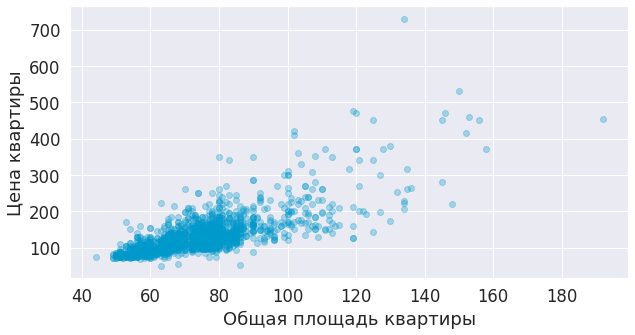

In [3]:
plt.figure(figsize=(10, 5))
plt.scatter(data['totsp'], data['price'], alpha=0.3, color=blue)
plt.xlabel('Общая площадь квартиры')
plt.ylabel('Цена квартиры');

Постройте с помощью PyMC линейную регрессию для предсказания цены квартиры (price) от ее общей площади (totsp). Используйте следующие распределения:
* Априорное распределение на коэффициенты --- нормальное с нулевым средним и среднеквадратичным разбросом 20
* Ошибка имеет нормальное распределение с нулевым средним
* Априорное распределение на дисперсию ошибки --- модуль распределения Коши

Запишите модель формулами:

$\sigma \sim HalfCauchy$

$\theta_0 \sim \mathcal{N}(0, 20^2)$

$\theta_1 \sim \mathcal{N}(0, 20^2)$

$(y\;|\;\theta_0,\theta_1,\sigma) \sim \mathcal{N}(\theta_0 + \theta_1 x, \sigma^2)$

Реализуйте эту модель и проведите 3000 итераций семплирования

In [4]:
with pm.Model() as model:
    # Априорные распределения
    sigma_prior = pm.HalfCauchy('sigma', beta=10, testval=1.)
    theta_0_prior = pm.Normal('theta_0', 0, sigma=20)
    theta_1_prior = pm.Normal('theta_1', 0, sigma=20)
    
    # объявляем данные
    x = pm.Data('x', data['totsp'])

    # распределение данных
    y_distr = pm.Normal('y', mu=theta_0_prior + theta_1_prior * x, sigma=sigma_prior, observed=data['price'])

    trace = pm.sample(3000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_1, theta_0, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 7000/7000 [03:30<00:00, 33.30draws/s] 
The acceptance probability does not match the target. It is 0.9953651212208067, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9394850502422426, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Постройте `pm.traceplot`. Что можно по нему сказать? Какое апострериорное распределение имеют параметры модели?

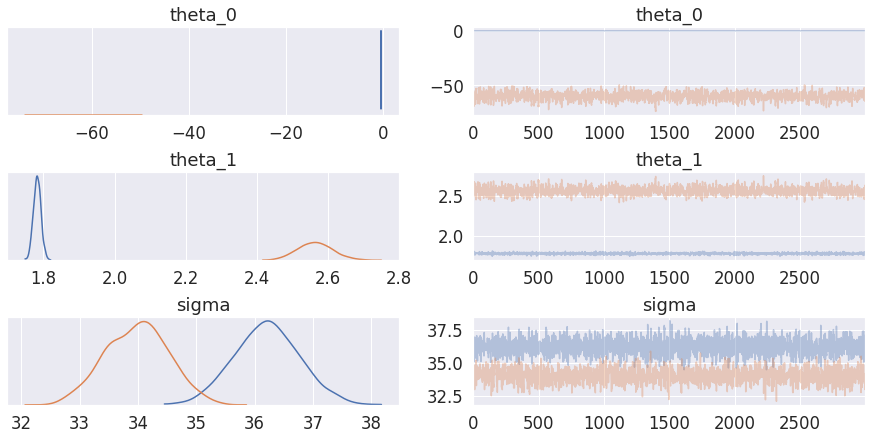

In [5]:
pm.traceplot(trace);

Теперь вам нужно построить предсказательный интервал для каждого $x$, взяв область, в которую попадает 95% вероятностной массы апостериорного распределения. Иначе говоря, на основе построенной модели нужно для каждой площади квартиры $x$ вычислить 95%-й диаппазон цен на квартиры с такой мощностью.

Для выполнения этого пункта задайте сетку значений площади квартиры и с помощью `pm.sample_posterior_predictive` проведите 10000 итераций семплирования из предиктивного распределения.

In [6]:
x_grid = np.arange(25, 201, 1)
with model:
    pm.set_data({'x': x_grid})
    post_pred = pm.sample_posterior_predictive(trace, samples=10000)

100%|██████████| 10000/10000 [00:19<00:00, 524.92it/s]


Какой размерности получится объект?

In [7]:
post_pred['y'].shape

(10000, 176)

На основе полученных семплов постройте график предсказательного интервала. Для этого можно взять квантили у семплов для каждого $x$.

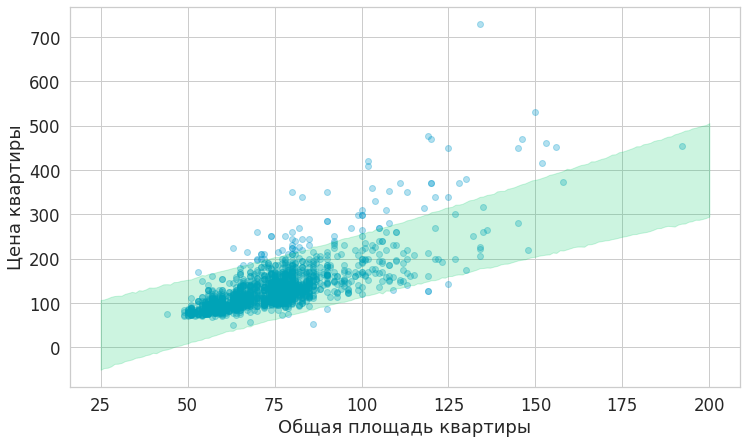

In [8]:
bounds = np.percentile(post_pred['y'], q=[2.5, 97.5], axis=0)

sns.set(font_scale=1.5, style='whitegrid')
plt.figure(figsize=(12, 7))
plt.scatter(data['totsp'], data['price'], alpha=0.3, color=blue)
plt.fill_between(x_grid, bounds[0], bounds[1], alpha=0.2, color=green)
plt.xlabel('Общая площадь квартиры')
plt.ylabel('Цена квартиры');
sns.set(font_scale=1.5)

Что вы можете сказать по этому графику?

Модель плохо описывает данные из-за наличия гетероскедастичности.

Предложите способ, как исправить модель. Реализуйте эту модель, постройте для нее график предсказательного интервала.

In [9]:
with pm.Model() as model:
    # Априорные распределения на параметры среднего
    theta_0_prior = pm.Normal('theta_0', 0, sigma=20)
    theta_1_prior = pm.Normal('theta_1', 0, sigma=20)
    
    # Априорные распределения на параметры дисперсии
    psi_0_prior = pm.Normal('psi_0', sigma=20)
    psi_1_prior = pm.HalfNormal('psi_1', sigma=20)
    
    # объявляем данные
    x = pm.Data('x', data['totsp'])

    # Распределение данных
    y_distr = pm.Normal('y', mu=theta_0_prior + theta_1_prior * x, 
                     sigma=psi_0_prior + psi_1_prior * x, observed=data['price'])

    trace = pm.sample(3000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [psi_1, psi_0, theta_1, theta_0]
Sampling 2 chains, 0 divergences: 100%|██████████| 7000/7000 [00:29<00:00, 236.13draws/s]
The acceptance probability does not match the target. It is 0.8909222878691316, but should be close to 0.8. Try to increase the number of tuning steps.


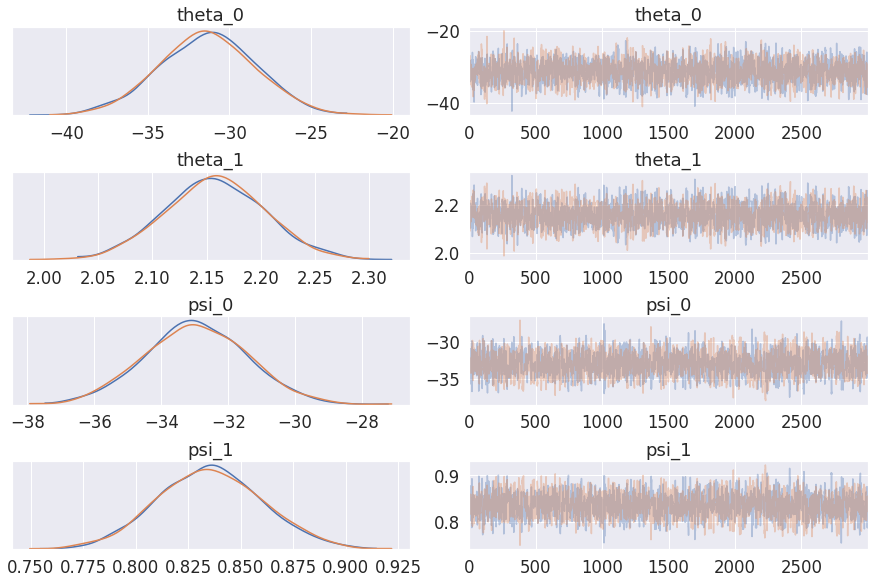

In [10]:
pm.traceplot(trace);

In [11]:
x_grid = np.arange(25, 201, 1)
with model:
    pm.set_data({'x': x_grid})
    post_pred = pm.sample_posterior_predictive(trace, samples=10000)

100%|██████████| 10000/10000 [00:26<00:00, 374.91it/s]


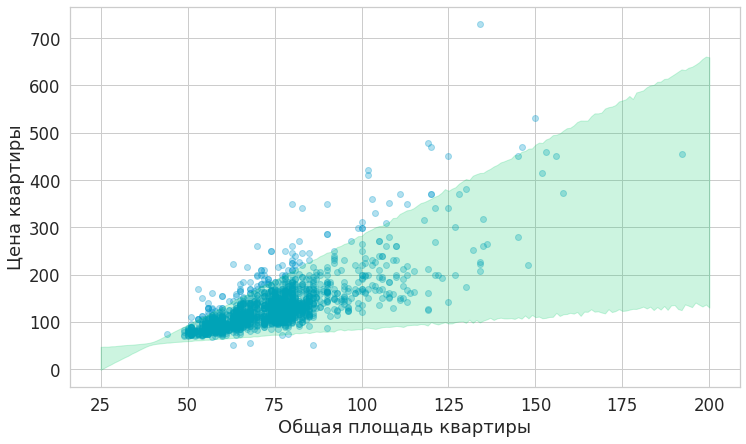

In [12]:
bounds = np.percentile(post_pred['y'], q=[2.5, 97.5], axis=0)

sns.set(font_scale=1.5, style='whitegrid')
plt.figure(figsize=(12, 7))
plt.scatter(data['totsp'], data['price'], alpha=0.3, color=blue)
plt.fill_between(x_grid, bounds[0], bounds[1], alpha=0.2, color=green)
plt.xlabel('Общая площадь квартиры')
plt.ylabel('Цена квартиры');
sns.set(font_scale=1.5)

Реализуйте ту же модель, взяв для ошибок распределение Стьюдента

In [13]:
with pm.Model() as model:
    # Априорные распределения на параметры среднего
    theta_0_prior = pm.Normal('theta_0', 0, sigma=20)
    theta_1_prior = pm.Normal('theta_1', 0, sigma=20)
    
    # Априорные распределения на параметры дисперсии
    psi_0_prior = pm.Normal('psi_0', sigma=20)
    psi_1_prior = pm.HalfNormal('psi_1', sigma=20)
    
    # объявляем данные
    x = pm.Data('x', data['totsp'])

    # Распределение данных
    y_distr = pm.StudentT('y', nu=5,
                       mu=theta_0_prior + theta_1_prior * x, 
                       sigma=psi_0_prior + psi_1_prior * x, 
                       observed=data['price'])

    trace = pm.sample(3000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [psi_1, psi_0, theta_1, theta_0]
Sampling 2 chains, 3 divergences: 100%|██████████| 7000/7000 [00:32<00:00, 212.74draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


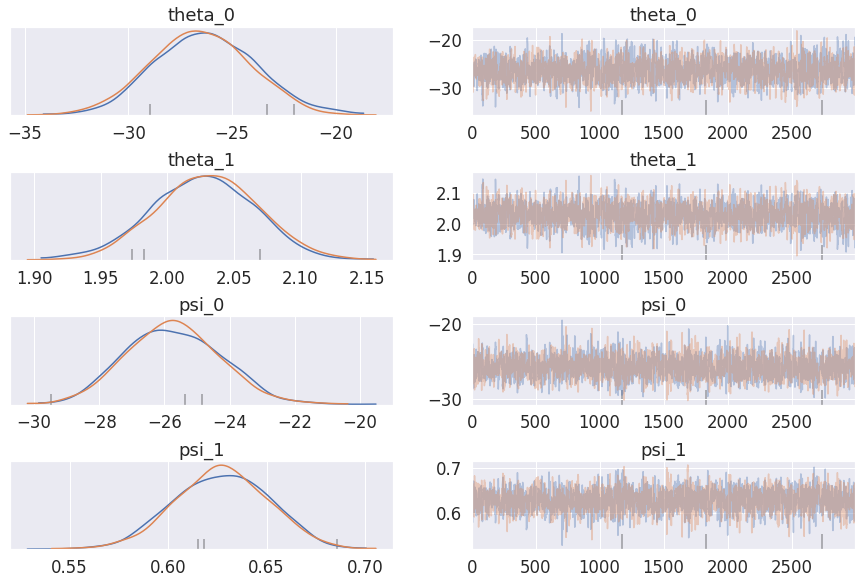

In [14]:
pm.traceplot(trace);

In [15]:
x_grid = np.arange(25, 201, 1)
with model:
    pm.set_data({'x': x_grid})
    post_pred = pm.sample_posterior_predictive(trace, samples=10000)

100%|██████████| 10000/10000 [00:18<00:00, 527.04it/s]


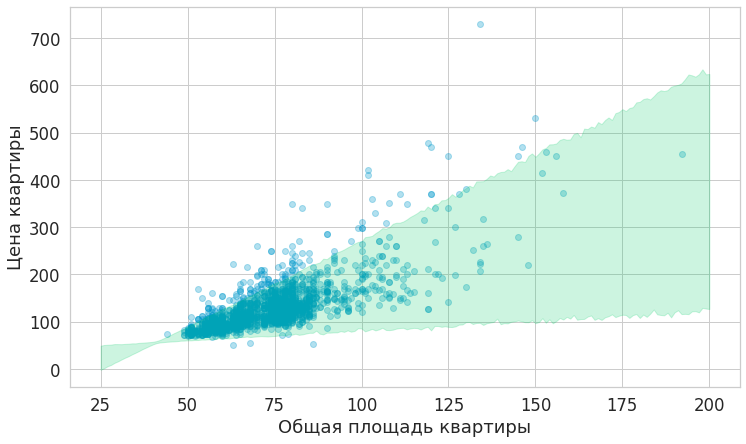

In [16]:
bounds = np.percentile(post_pred['y'], q=[2.5, 97.5], axis=0)

sns.set(font_scale=1.5, style='whitegrid')
plt.figure(figsize=(12, 7))
plt.scatter(data['totsp'], data['price'], alpha=0.3, color=blue)
plt.fill_between(x_grid, bounds[0], bounds[1], alpha=0.2, color=green)
plt.xlabel('Общая площадь квартиры')
plt.ylabel('Цена квартиры');
sns.set(font_scale=1.5)

Теперь проведем небольшую аналитику. Допустим, мы хотим купить квартиру площадью 75 квадратных метров. Простройте график плотности предсказательного распределения цены такой квартиры. Посчитайте также вероятность того, что квартира площадью 75 квадратных метров имеет цену не более 100.

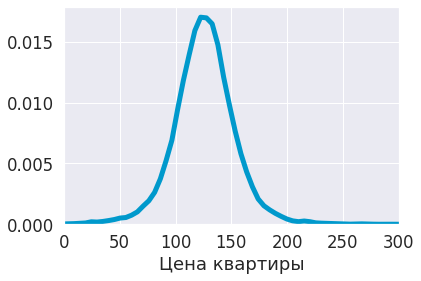

In [18]:
sns.kdeplot(post_pred['y'][:, 50], lw=5, color=blue)
plt.xlabel('Цена квартиры')
plt.xlim((0, 300));

In [19]:
(post_pred['y'][:, 50] <= 100).mean()

0.1379

Насколько вообще изменяется цена квартиры при увеличении ее площади на 1 метр? Постройте для этого апостериорное распределение этого параметра, а также посчитайте среднее значение и 95%-й интервал

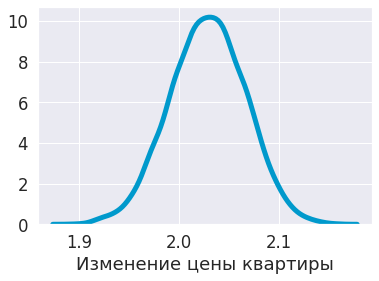

In [20]:
sns.kdeplot(trace['theta_1'], lw=5, color=blue)
plt.xlabel('Изменение цены квартиры');

In [21]:
trace['theta_1'].mean()

2.028469337326669

In [24]:
np.percentile(trace['theta_1'], q=[2.5, 97.5])

array([1.95372745, 2.1003632 ])

Можно было сделать то же самое с помощью функции `pm.plot_posterior`, но не портив семпл

In [25]:
with pm.Model() as model:
    # Априорные распределения на параметры среднего
    theta_0_prior = pm.Normal('theta_0', 0, sigma=20)
    theta_1_prior = pm.Normal('theta_1', 0, sigma=20)
    
    # Априорные распределения на параметры дисперсии
    psi_0_prior = pm.Normal('psi_0', sigma=20)
    psi_1_prior = pm.HalfNormal('psi_1', sigma=20)
    
    # объявляем данные
    x = pm.Data('x', data['totsp'])

    # Распределение данных
    y_distr = pm.Normal('y', mu=theta_0_prior + theta_1_prior * x, 
                     sigma=psi_0_prior + psi_1_prior * x, observed=data['price'])

    trace = pm.sample(3000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [psi_1, psi_0, theta_1, theta_0]
Sampling 2 chains, 0 divergences: 100%|██████████| 7000/7000 [00:17<00:00, 411.05draws/s]
The acceptance probability does not match the target. It is 0.8916412834509112, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9020446734984489, but should be close to 0.8. Try to increase the number of tuning steps.


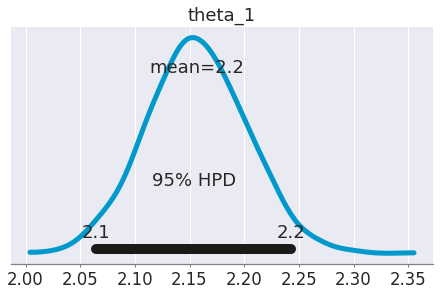

In [26]:
pm.plot_posterior(
    trace, 
    var_names=['theta_1'],
    credible_interval=0.95,
    linewidth=5,
    color=blue);